Written report see end of the file

In [223]:
import numpy as np
import os
import collections
import copy
import pickle
import random
import time
import matplotlib.pyplot as plt

In [2]:
"""
Read alignment file into numpy array
"""
def func_file2seq(filepath):
    seq_list = []
    with open(filepath,'r') as f1:
        for line in f1:
            if line[0] == '>':
                continue
            else:
                seq = list(line.strip().replace('\n','').upper())
                seq_list.append(seq)
    return np.array(seq_list)

In [ ]:
'''
Due to limited computational power and lack of optimization, this code takes forever to compute.
Therefore, randomly sampled 100 sequence from each class and saved. save memory as well.

'''

super_directory ="/home/chingyuenliu/TTIC31160_bioinfo/hw2/Super"
twil_directory ="/home/chingyuenliu/TTIC31160_bioinfo/hw2/Twil"

super_seq_list = []
for root, dirs, files in os.walk(super_directory):
    for file in files:
        if file.endswith(".fasta") and file.startswith('d'):
            super_seq_list.append(func_file2seq(os.path.join(root,file)))
            
twil_seq_list = []
for root, dirs, files in os.walk(twil_directory):
    for file in files:
        if file.endswith(".fasta") and file.startswith('d'):
            twil_seq_list.append(func_file2seq(os.path.join(root,file)))

random.shuffle(super_seq_list)
random.shuffle(twil_seq_list)

with open("super_dataset_sampled100.txt", "wb") as fp:   #Pickling
    pickle.dump(super_seq_list[:100], fp)

with open("twil_dataset_sampled100.txt","wb") as fp:
    pickle.dump(twil_seq_list[:100], fp)


In [3]:
"""
function to convert aligned sequence to pure sequence without '-' mark 
"""

def pure_seq(seq_list):
    pure_list=[]
    for i in seq_list:
        seq_pair = []
        for j in i:
            seq_pair.append([aa for aa in j if aa != '-' ])
        pure_list.append(seq_pair)
    return pure_list

In [4]:
"""
load blosum file as a mtrix
"""

def blosum2mat(blosum_filepath):
    seq_list = []
    with open(blosum_filepath,'r') as f1:
        for line in f1:
            if line[0] == '#' or line[3] =='A':
                continue
            else:
                seq = list(map(float,line[1:].strip().replace('\n','').split()))
                seq_list.append(seq)
    return np.array(seq_list)[:20,:20]

In [47]:
"""
The code to calculate the log(x+y+z) known log(x), log(y) and log(z)
"""
def logsum(num_list):
    #already logrithmic entry
    if len(num_list) == 0: return -np.inf
    anker = np.inf
    second_half = np.inf
    if type(num_list) == list:
        num_list = np.array(num_list).reshape(-1)

    else:
        num_list = num_list.reshape(-1)

        
    for i in range(num_list.shape[0]):
        if (not np.isinf(num_list[i])) and (not np.isnan(num_list[i])):
            anker = num_list[i]
            second_half = np.delete(num_list,i)
            break
    
    if anker == np.inf:
        return -np.inf
    second_half = np.clip(second_half - anker, -np.inf,1233.9)
    return anker+np.log(np.exp(second_half).sum()+1)
    

In [6]:
"""
Helper function when calculate backward matrix to determine index
"""

def index_determ(i,j,s2):
    if s2 == 0:
        return i+1, j+1, s2
    elif s2 == 1:
        return i+1, j, s2
    elif s2 == 2:
        return i, j+1, s2

In [7]:
one2all ={'A': ('A', 'ALA', 'alanine'),
              'R': ('R', 'ARG', 'arginine'),
              'N': ('N', 'ASN', 'asparagine'),
              'D': ('D', 'ASP', 'aspartic acid'),
              'C': ('C', 'CYS', 'cysteine'),
              'Q': ('Q', 'GLN', 'glutamine'),
              'E': ('E', 'GLU', 'glutamic acid'),
              'G': ('G', 'GLY', 'glycine'),
              'H': ('H', 'HIS', 'histidine'),
              'I': ('I', 'ILE', 'isoleucine'),
              'L': ('L', 'LEU', 'leucine'),
              'K': ('K', 'LYS', 'lysine'),
              'M': ('M', 'MET', 'methionine'),
              'F': ('F', 'PHE', 'phenylalanine'),
              'P': ('P', 'PRO', 'proline'),
              'S': ('S', 'SER', 'serine'),
              'T': ('T', 'THR', 'threonine'),
              'W': ('W', 'TRP', 'tryptophan'),
              'Y': ('Y', 'TYR', 'tyrosine'),
              'V': ('V', 'VAL', 'valine'),
              'X': ('X', 'GLX', 'glutaminx'),
              'Z': ('Z', 'GLI', 'glycine'),
              'J': ('J', 'NLE', 'norleucine'),
                'U': ('U', 'CYC', 'cysteinc')}

In [8]:
"""
dictionary to convert aa to num
"""

aa2index={}
for i, aa in enumerate(list(one2all.keys())):
    if i == 20: break
    aa2index[aa] = i

In [36]:
"""
load training data
"""
#load training data

with open("super_dataset_sampled100.txt", "rb") as fp:   # Unpickling
    super_list_sampled = pickle.load(fp)
    
with open("twil_dataset_sampled100.txt", "rb") as fp:   # Unpickling
    twil_list_sampled = pickle.load(fp)

super_list_train=super_list_sampled[:90]
super_list_val = super_list_sampled[90:]

twil_list_train = twil_list_sampled[:90]
twil_list_val = twil_list_sampled[90:]

In [38]:
"""
calcualte blosum frequence as match state emit probability and 
amino acid background frequency as insertion state emit frequency
"""


blosum_filepath = "/home/chingyuenliu/TTIC31160_bioinfo/hw2/BLOSUM62"

blosum = blosum2mat(blosum_filepath)

blosum_f = np.exp(blosum)

aa_background_f = np.zeros(20)
for i in super_list_train:
    values,counts = np.unique(i,return_counts=True)
    for v in range(values.shape[0]):
        if values[v] in aa2index:
            aa_background_f[aa2index[values[v]]] += counts[v]
aa_background_f=aa_background_f/aa_background_f.sum()  

for i in range(blosum_f.shape[0]):
    for j in range(blosum_f.shape[1]):
        blosum_f[i,j] = blosum_f[i,j] * aa_background_f[i] * aa_background_f[j]
blosum_f = blosum_f/blosum_f.sum()

In [252]:
"""initiate the parameters of a local alignment HMM model"""
def l_para_init():
    states = ["Match", "Insert_X", "Insert_Y"]

    l_para = {}


    emit_M = np.log(blosum_f)
    emit_X = np.tile(np.log(aa_background_f).reshape(-1,1),[1,20])
    emit_Y = np.tile(np.log(aa_background_f), [20,1])

    l_para['lgtau'] = np.log(0.1)
    tau = 0.1
    de = 0.3
    eta = 0.6

    l_para['trans_mat'] = np.array([1-2*de,de,de,1-eta-tau,eta,0,1-eta-tau,0,eta]).reshape([3,3])

    l_para['trans_mat'] = np.log(l_para['trans_mat'])
    #MM,MX,MY,XM,XX,XY,YM,YX,YY
    #there is no transition probability from match state to end state
    
    emit_mat = np.zeros([20,20,3])
    emit_mat[:,:,0] = emit_M
    emit_mat[:,:,1] = emit_X
    emit_mat[:,:,2] = emit_Y

    l_para['emit_mat'] = emit_mat
    
    return l_para

In [253]:
"""initiate the parameters of a global alignment HMM model"""

def g_para_init():
    states = ["Match", "Insert_X", "Insert_Y"]
    g_para = {}


    emit_M = np.log(blosum_f)
    emit_X = np.tile(np.log(aa_background_f).reshape(-1,1),[1,20])
    emit_Y = np.tile(np.log(aa_background_f), [20,1])

    g_para['lgtau'] = np.log(0.1)

    tau = 0.1
    de = 0.3
    eta = 0.6


    
    g_para['trans_mat'] = np.array([1-2*de-tau,de,de,1-eta-tau,eta,0,1-eta-tau,0,eta]).reshape([3,3])
    g_para['trans_mat'] = np.log(g_para['trans_mat'])
    #MM,MX,MY,XM,XX,XY,YM,YX,YY
    #here the match state has transition probability to ending state
    
    emit_mat = np.zeros([20,20,3])
    emit_mat[:,:,0] = emit_M
    emit_mat[:,:,1] = emit_X
    emit_mat[:,:,2] = emit_Y

    g_para['emit_mat'] = emit_mat
    
    return g_para

In [41]:
l_para = l_para_init()

/home/chingyuenliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


In [18]:
"""
function to update match states of a local alignment model when do forward algorithm
"""
def forward_M_compute_l(i,j):
    if i == 0 or j == 0:
        return -np.inf
        
    fm = f_matrix[i-1,j-1,0]
    fx = f_matrix[i-1,j-1,1]
    fy = f_matrix[i-1,j-1,2]
    
    inf_index = [index for index, value in enumerate([fm,fx,fy]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            log_list.append(l_para['emit_mat'][aa2index[seq1[i-1]],aa2index[seq2[j-1]]][0] + \
                           l_para['trans_mat'][index,0] + f_matrix[i-1,j-1,index]
                           )
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)


In [19]:
"""
function to update match states of a local alignment model when do backward algorithm
"""
def backward_M_compute_l(i,j):

    if i >= m and j >= n: return -np.inf
        
    if i == m and j < n:
        bm = -np.inf
        bx = -np.inf    
        by = b_matrix[i,j+1,2]
    elif i < m and j == n:
        bm = -np.inf
        by = -np.inf
        bx = b_matrix[i+1,j,1]
    else:
        bm = b_matrix[i+1,j+1,0]
        bx = b_matrix[i+1,j,1]
        by = b_matrix[i,j+1,2]
    
    inf_index = [index for index, value in enumerate([bm,bx,by]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            if index == 0:
                log_list.append(l_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][0] + \
                           l_para['trans_mat'][0,index] + b_matrix[i+1,j+1,index]
                           )
            if index == 1:
                log_list.append(l_para['emit_mat'][aa2index[seq1[i]],0][1] + \
                           l_para['trans_mat'][0,index] + b_matrix[i+1,j,index] )
            if index == 2:
                log_list.append(l_para['emit_mat'][0,aa2index[seq2[j]]][2] + \
                           l_para['trans_mat'][0,index] + b_matrix[i,j+1,index] )                           
            
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)


In [20]:
"""
function to update insertion states in sequence1 of a local alignment model when do forward algorithm
"""
def forward_X_compute_l(i,j):
    if i == 0:
        return -np.inf
        
    fm = f_matrix[i-1,j,0]
    fx = f_matrix[i-1,j,1]
    
    inf_index = [index for index, value in enumerate([fm,fx,-np.inf]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            log_list.append(l_para['emit_mat'][aa2index[seq1[i-1]],0][1] + \
                           l_para['trans_mat'][index,1] + f_matrix[i-1,j,index]
                           )
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)

In [21]:
"""
function to update insertion states in sequence1 of a local alignment model when do backward algorithm
"""
def backward_X_compute_l(i,j):

    if i >= m : return -np.inf
    if j > n: return -np.inf
    
    by = -np.inf

    if i < m and j == n:
        bm = -np.inf
        by = -np.inf        
        bx = b_matrix[i+1,j,1]
    else:
        bm = b_matrix[i+1,j+1,0]
        bx = b_matrix[i+1,j,1]

    
    inf_index = [index for index, value in enumerate([bm,bx,-np.inf]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            if index == 0:
                log_list.append(l_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][0] + \
                           l_para['trans_mat'][1,index] + b_matrix[i+1,j+1,index]
                           )
            if index == 1:
                log_list.append(l_para['emit_mat'][aa2index[seq1[i]],0][1] + \
                           l_para['trans_mat'][1,index] + b_matrix[i+1,j,index] )                    
            
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)


In [22]:
"""
function to update insertion states in sequence2 of a local alignment model when do forward algorithm
"""
def forward_Y_compute_l(i,j):
    if j == 0:
        return -np.inf
        
    fm = f_matrix[i,j-1,0]
    fy = f_matrix[i,j-1,2]
    
    inf_index = [index for index, value in enumerate([fm, -np.inf, fy]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            log_list.append(l_para['emit_mat'][0,aa2index[seq2[j-1]]][2] + \
                           l_para['trans_mat'][index,2] + f_matrix[i,j-1,index]
                           )
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)

In [23]:
"""
function to update insertion states in sequence2 of a local alignment model when do backward algorithm
"""
def backward_Y_compute_l(i,j):

    
    if j >= n: return -np.inf
    if i > m : return -np.inf
    
    bx = -np.inf

    if i == m and j < n:
        bm = -np.inf      
        by = b_matrix[i,j+1,2]
    else:
        bm = b_matrix[i+1,j+1,0]
        by = b_matrix[i,j+1,2]

    
    inf_index = [index for index, value in enumerate([bm,-np.inf,by]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            if index == 0:
                log_list.append(l_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][0] + \
                           l_para['trans_mat'][2,index] + b_matrix[i+1,j+1,index]
                           )
            if index == 2:
                log_list.append(l_para['emit_mat'][0,aa2index[seq2[j]]][2] + \
                           l_para['trans_mat'][2,index] + b_matrix[i,j+1,index] )                    
            
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)

In [ ]:
"""HMM model parameter training started"""

In [257]:
"""initialize the model parameter"""
l_para = l_para_init()

/home/chingyuenliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


In [258]:
"""
computation of updating the model parameter

due to limit of computational power and lack of optimization, each sample is only do EM once.

Here is to training the local alignment model on superfamily dataset

"""
for seq_pair in super_list_train:

    seq1,seq2 = pure_seq([seq_pair])[0]
    #local
    m = len(seq1)
    n = len(seq2)

    for loop in range(1):
        #order match:0,x:1,y:2
        f_matrix = np.full([m+1,n+1, len(states)], -np.inf)
        b_matrix = np.full([m+1,n+1, len(states)], -np.inf)

        #the forward matrix is initiate with only insertion states has transition probabilit from begin state
        #match state does not have transition probability
        
        f_matrix[0,0,1] = np.log(0.5)
        f_matrix[0,0,2] = np.log(0.5)
        for i in range(0,m+1):
            for j in range(0,n+1):
                if i==0 and j ==0: continue
                f_matrix[i,j,0] = forward_M_compute_l(i,j)
                f_matrix[i,j,1] = forward_X_compute_l(i,j)
                f_matrix[i,j,2] = forward_Y_compute_l(i,j)            

        #the backward matrix is initiated with only tau value on two insertion states
        b_matrix[m,n,1] = l_para['lgtau']
        b_matrix[m,n,2] = l_para['lgtau']
        for i in range(m,-1,-1):
            for j in range(n,-1,-1):
                if i ==m and j == n: continue
                b_matrix[i,j,0] = backward_M_compute_l(i,j)
                b_matrix[i,j,1] = backward_X_compute_l(i,j)
                b_matrix[i,j,2] = backward_Y_compute_l(i,j)



        gamma_matrix=f_matrix+b_matrix


        #Update parameter value
        
        trans_mat_new = np.zeros(l_para['trans_mat'].shape)
        for s1 in range(trans_mat_new.shape[0]):
            for s2 in range(trans_mat_new.shape[1]):
                if (s1 == 1 and s2 ==2) or (s1 ==2 and s2 ==1):
                    trans_mat_new[s1,s2] = -np.inf
                    continue
                mat = np.zeros([m,n])
                for i in range(m):
                    for j in range(n):
                        mat[i,j] = f_matrix[i,j,s1]+b_matrix[index_determ(i,j,s2)] + l_para['trans_mat'][s1,s2] + \
                                    l_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][s2]
                trans_mat_new[s1,s2] = logsum(mat) - logsum(gamma_matrix[:,:,s1])


        l_para['lgtau'] = np.clip(np.log((3-np.exp(trans_mat_new).sum())/2),-10,-1e-5)

        emit_mat_new = np.zeros(l_para['emit_mat'].shape)

        for aa1 in aa2index:
            for aa2 in aa2index:
                aa1_index = [index for index,value in enumerate(seq1) if value == aa1]
                aa2_index = [index for index,value in enumerate(seq2) if value == aa2]

                value_list = []
                for aa1_i in aa1_index:
                    for aa2_i in aa2_index:
                        value_list.append(gamma_matrix[aa1_i,aa2_i])

                if len(value_list) == 0:
                    for k in range(gamma_matrix.shape[2]):
                        emit_mat_new[aa2index[aa1],aa2index[aa2],k] = -np.inf
                    continue

                value_np = np.array(value_list)  

                for k in range(value_np.shape[1]):
                    emit_mat_new[aa2index[aa1],aa2index[aa2],k] = logsum(value_np[:,k])

        for it in range(emit_mat_new.shape[2]):
            emit_mat_new[:,:,it] -= logsum(gamma_matrix[:,:,it])

        for it in range(20):
            emit_mat_new[it,0,1] = logsum(emit_mat_new[it,:,1])
            emit_mat_new[0,it,2] = logsum(emit_mat_new[:,it,2])

        emit_mat_new[:,:,1] = np.tile(emit_mat_new[:,0,1].reshape(-1,1),[1,20])
        emit_mat_new[:,:,2] = np.tile(emit_mat_new[0,:,2].reshape(1,-1),[20,1])

        emit_mat_new = np.clip(emit_mat_new,-10,-1e-5)

        l_para['emit_mat'] = emit_mat_new
        l_para['trans_mat'] = trans_mat_new

    


In [262]:
"""save the model parameter
"""
l_para_super = copy.deepcopy(l_para)

In [71]:
"""initiate the global HMM parameter"""

g_para = g_para_init()


/home/chingyuenliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


In [72]:
"""
function to update match states of a global alignment model when do forward algorithm
"""
def forward_M_compute_g(i,j):
    if i == 0 or j == 0:
        return -np.inf
        
    fm = f_matrix[i-1,j-1,0]
    fx = f_matrix[i-1,j-1,1]
    fy = f_matrix[i-1,j-1,2]
    
    inf_index = [index for index, value in enumerate([fm,fx,fy]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            log_list.append(g_para['emit_mat'][aa2index[seq1[i-1]],aa2index[seq2[j-1]]][0] + \
                           g_para['trans_mat'][index,0] + f_matrix[i-1,j-1,index]
                           )
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)


In [73]:
"""
function to update match states of a global alignment model when do backward algorithm
"""
def backward_M_compute_g(i,j):

    if i >= m and j >= n: return -np.inf
        
    if i == m and j < n:
        bm = -np.inf
        bx = -np.inf    
        by = b_matrix[i,j+1,2]
    elif i < m and j == n:
        bm = -np.inf
        by = -np.inf
        bx = b_matrix[i+1,j,1]
    else:
        bm = b_matrix[i+1,j+1,0]
        bx = b_matrix[i+1,j,1]
        by = b_matrix[i,j+1,2]
    
    inf_index = [index for index, value in enumerate([bm,bx,by]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            if index == 0:
                log_list.append(g_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][0] + \
                           g_para['trans_mat'][0,index] + b_matrix[i+1,j+1,index]
                           )
            if index == 1:
                log_list.append(g_para['emit_mat'][aa2index[seq1[i]],0][1] + \
                           g_para['trans_mat'][0,index] + b_matrix[i+1,j,index] )
            if index == 2:
                log_list.append(g_para['emit_mat'][0,aa2index[seq2[j]]][2] + \
                           g_para['trans_mat'][0,index] + b_matrix[i,j+1,index] )                           
            
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)


In [74]:
"""
function to update insert states of a global alignment model when do forward algorithm
"""
def forward_X_compute_g(i,j):
    if i == 0:
        return -np.inf
        
    fm = f_matrix[i-1,j,0]
    fx = f_matrix[i-1,j,1]
    
    inf_index = [index for index, value in enumerate([fm,fx,-np.inf]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            log_list.append(g_para['emit_mat'][aa2index[seq1[i-1]],0][1] + \
                           g_para['trans_mat'][index,1] + f_matrix[i-1,j,index]
                           )
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)

In [75]:
"""
function to update insert states of a global alignment model when do backward algorithm
"""
def backward_X_compute_g(i,j):

    if i >= m : return -np.inf
    if j > n: return -np.inf
    
    by = -np.inf

    if i < m and j == n:
        bm = -np.inf
        by = -np.inf        
        bx = b_matrix[i+1,j,1]
    else:
        bm = b_matrix[i+1,j+1,0]
        bx = b_matrix[i+1,j,1]

    
    inf_index = [index for index, value in enumerate([bm,bx,-np.inf]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            if index == 0:
                log_list.append(g_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][0] + \
                           g_para['trans_mat'][1,index] + b_matrix[i+1,j+1,index]
                           )
            if index == 1:
                log_list.append(g_para['emit_mat'][aa2index[seq1[i]],0][1] + \
                           g_para['trans_mat'][1,index] + b_matrix[i+1,j,index] )                    
            
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)


In [76]:
"""
function to update insert states of a global alignment model when do forward algorithm
"""
def forward_Y_compute_g(i,j):
    if j == 0:
        return -np.inf
        
    fm = f_matrix[i,j-1,0]
    fy = f_matrix[i,j-1,2]
    
    inf_index = [index for index, value in enumerate([fm, -np.inf, fy]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            log_list.append(g_para['emit_mat'][0,aa2index[seq2[j-1]]][2] + \
                           g_para['trans_mat'][index,2] + f_matrix[i,j-1,index]
                           )
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)

In [77]:
"""
function to update insert states of a global alignment model when do backward algorithm
"""
def backward_Y_compute_g(i,j):

    
    if j >= n: return -np.inf
    if i > m : return -np.inf
    
    bx = -np.inf

    if i == m and j < n:
        bm = -np.inf      
        by = b_matrix[i,j+1,2]
    else:
        bm = b_matrix[i+1,j+1,0]
        by = b_matrix[i,j+1,2]

    
    inf_index = [index for index, value in enumerate([bm,-np.inf,by]) if value != -np.inf]
    if len(inf_index) == 0:
        return -np.inf
    else:
        log_list = []
        for index in inf_index:
            if index == 0:
                log_list.append(g_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][0] + \
                           g_para['trans_mat'][2,index] + b_matrix[i+1,j+1,index]
                           )
            if index == 2:
                log_list.append(g_para['emit_mat'][0,aa2index[seq2[j]]][2] + \
                           g_para['trans_mat'][2,index] + b_matrix[i,j+1,index] )                    
            
        if len(log_list) == 1:
            return log_list[0]
        else:
            return logsum(log_list)

In [78]:
"""
computation of updating the model parameter

due to limit of computational power and lack of optimization, each sample is only do EM once.

Here is to training the global alignment model on superfamily dataset

"""
#global
for seq_pair in super_list_train:
    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)
    #order match:0,x:1,y:2
    
    for loop in range(1):
        f_matrix = np.full([m+1,n+1, len(states)], -np.inf)
        b_matrix = np.full([m+1,n+1, len(states)], -np.inf)

        f_matrix[0,0,0] = np.log(1/3)
        f_matrix[0,0,1] = np.log(1/3)
        f_matrix[0,0,2] = np.log(1/3)

        for i in range(0,m+1):
            for j in range(0,n+1):
                if i==0 and j ==0: continue
                f_matrix[i,j,0] = forward_M_compute_g(i,j)
                f_matrix[i,j,1] = forward_X_compute_g(i,j)
                f_matrix[i,j,2] = forward_Y_compute_g(i,j)

        b_matrix[m,n,0] = g_para['lgtau']
        b_matrix[m,n,1] = g_para['lgtau']
        b_matrix[m,n,2] = g_para['lgtau']

        for i in range(m,-1,-1):
            for j in range(n,-1,-1):
                if i ==m and j == n: continue
                b_matrix[i,j,0] = backward_M_compute_g(i,j)
                b_matrix[i,j,1] = backward_X_compute_g(i,j)
                b_matrix[i,j,2] = backward_Y_compute_g(i,j)



        gamma_matrix=f_matrix+b_matrix


        trans_mat_new = np.zeros(g_para['trans_mat'].shape)
        for s1 in range(trans_mat_new.shape[0]):
            for s2 in range(trans_mat_new.shape[1]):
                if (s1 == 1 and s2 ==2) or (s1 ==2 and s2 ==1):
                    trans_mat_new[s1,s2] = -np.inf
                    continue
                mat = np.zeros([m,n])
                for i in range(m):
                    for j in range(n):
                        mat[i,j] = f_matrix[i,j,s1]+b_matrix[index_determ(i,j,s2)] + g_para['trans_mat'][s1,s2] + \
                                    g_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][s2]
                trans_mat_new[s1,s2] = logsum(mat) - logsum(gamma_matrix[:,:,s1])


        g_para['lgtau'] = np.clip(np.log((3-np.exp(trans_mat_new).sum())/3), -10,-1e-5)

        emit_mat_new = np.zeros(g_para['emit_mat'].shape)

        for aa1 in aa2index:
            for aa2 in aa2index:
                aa1_index = [index for index,value in enumerate(seq1) if value == aa1]
                aa2_index = [index for index,value in enumerate(seq2) if value == aa2]

                value_list = []
                for aa1_i in aa1_index:
                    for aa2_i in aa2_index:
                        value_list.append(gamma_matrix[aa1_i,aa2_i])

                if len(value_list) == 0:
                    for k in range(gamma_matrix.shape[2]):
                        emit_mat_new[aa2index[aa1],aa2index[aa2],k] = -np.inf
                    continue

                value_np = np.array(value_list)  

                for k in range(value_np.shape[1]):
                    emit_mat_new[aa2index[aa1],aa2index[aa2],k] = logsum(value_np[:,k])

        for it in range(emit_mat_new.shape[2]):
            emit_mat_new[:,:,it] -= logsum(gamma_matrix[:,:,it])

        for it in range(20):
            emit_mat_new[it,0,1] = logsum(emit_mat_new[it,:,1])
            emit_mat_new[0,it,2] = logsum(emit_mat_new[:,it,2])

        emit_mat_new[:,:,1] = np.tile(emit_mat_new[:,0,1].reshape(-1,1),[1,20])
        emit_mat_new[:,:,2] = np.tile(emit_mat_new[0,:,2].reshape(1,-1),[20,1])

        emit_mat_new = np.clip(emit_mat_new,-10,-1e-5)

        g_para['emit_mat'] = emit_mat_new
        g_para['trans_mat'] = trans_mat_new

In [93]:
g_para_super = copy.deepcopy(g_para)

In [264]:
l_para = l_para_init()

/home/chingyuenliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


In [106]:
"""
computation of updating the model parameter

due to limit of computational power and lack of optimization, each sample is only do EM once.

Here is to training the local alignment model on twilight dataset

"""
for seq_pair in twil_list_train:

    seq1,seq2 = pure_seq([seq_pair])[0]
    #local
    m = len(seq1)
    n = len(seq2)

    for loop in range(1):
        #order match:0,x:1,y:2
        f_matrix = np.full([m+1,n+1, len(states)], -np.inf)
        b_matrix = np.full([m+1,n+1, len(states)], -np.inf)

        f_matrix[0,0,1] = np.log(0.5)
        f_matrix[0,0,2] = np.log(0.5)
        for i in range(0,m+1):
            for j in range(0,n+1):
                if i==0 and j ==0: continue
                f_matrix[i,j,0] = forward_M_compute_l(i,j)
                f_matrix[i,j,1] = forward_X_compute_l(i,j)
                f_matrix[i,j,2] = forward_Y_compute_l(i,j)            

        b_matrix[m,n,1] = l_para['lgtau']
        b_matrix[m,n,2] = l_para['lgtau']
        for i in range(m,-1,-1):
            for j in range(n,-1,-1):
                if i ==m and j == n: continue
                b_matrix[i,j,0] = backward_M_compute_l(i,j)
                b_matrix[i,j,1] = backward_X_compute_l(i,j)
                b_matrix[i,j,2] = backward_Y_compute_l(i,j)



        gamma_matrix=f_matrix+b_matrix


        trans_mat_new = np.zeros(l_para['trans_mat'].shape)
        for s1 in range(trans_mat_new.shape[0]):
            for s2 in range(trans_mat_new.shape[1]):
                if (s1 == 1 and s2 ==2) or (s1 ==2 and s2 ==1):
                    trans_mat_new[s1,s2] = -np.inf
                    continue
                mat = np.zeros([m,n])
                for i in range(m):
                    for j in range(n):
                        mat[i,j] = f_matrix[i,j,s1]+b_matrix[index_determ(i,j,s2)] + l_para['trans_mat'][s1,s2] + \
                                    l_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][s2]
                trans_mat_new[s1,s2] = logsum(mat) - logsum(gamma_matrix[:,:,s1])


        l_para['lgtau'] = np.clip(np.log((3-np.exp(trans_mat_new).sum())/2), -10,-1e-5)

        emit_mat_new = np.zeros(l_para['emit_mat'].shape)

        for aa1 in aa2index:
            for aa2 in aa2index:
                aa1_index = [index for index,value in enumerate(seq1) if value == aa1]
                aa2_index = [index for index,value in enumerate(seq2) if value == aa2]

                value_list = []
                for aa1_i in aa1_index:
                    for aa2_i in aa2_index:
                        value_list.append(gamma_matrix[aa1_i,aa2_i])

                if len(value_list) == 0:
                    for k in range(gamma_matrix.shape[2]):
                        emit_mat_new[aa2index[aa1],aa2index[aa2],k] = -np.inf
                    continue

                value_np = np.array(value_list)  

                for k in range(value_np.shape[1]):
                    emit_mat_new[aa2index[aa1],aa2index[aa2],k] = logsum(value_np[:,k])

        for it in range(emit_mat_new.shape[2]):
            emit_mat_new[:,:,it] -= logsum(gamma_matrix[:,:,it])

        for it in range(20):
            emit_mat_new[it,0,1] = logsum(emit_mat_new[it,:,1])
            emit_mat_new[0,it,2] = logsum(emit_mat_new[:,it,2])

        emit_mat_new[:,:,1] = np.tile(emit_mat_new[:,0,1].reshape(-1,1),[1,20])
        emit_mat_new[:,:,2] = np.tile(emit_mat_new[0,:,2].reshape(1,-1),[20,1])

        emit_mat_new = np.clip(emit_mat_new,-10,-1e-5)

        l_para['emit_mat'] = emit_mat_new
        l_para['trans_mat'] = trans_mat_new

    


/home/chingyuenliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


In [108]:
l_para_twil = copy.deepcopy(l_para)

In [194]:
g_para = g_para_init()


/home/chingyuenliu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


In [195]:
"""
computation of updating the model parameter

due to limit of computational power and lack of optimization, each sample is only do EM once.

Here is to training the global alignment model on twilight dataset

"""
#global
for seq_pair in twil_list_train:
    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)
    #order match:0,x:1,y:2
    
    for loop in range(1):
        f_matrix = np.full([m+1,n+1, len(states)], -np.inf)
        b_matrix = np.full([m+1,n+1, len(states)], -np.inf)

        f_matrix[0,0,0] = np.log(1/3)
        f_matrix[0,0,1] = np.log(1/3)
        f_matrix[0,0,2] = np.log(1/3)

        for i in range(0,m+1):
            for j in range(0,n+1):
                if i==0 and j ==0: continue
                f_matrix[i,j,0] = forward_M_compute_g(i,j)
                f_matrix[i,j,1] = forward_X_compute_g(i,j)
                f_matrix[i,j,2] = forward_Y_compute_g(i,j)

        b_matrix[m,n,0] = g_para['lgtau']
        b_matrix[m,n,1] = g_para['lgtau']
        b_matrix[m,n,2] = g_para['lgtau']

        for i in range(m,-1,-1):
            for j in range(n,-1,-1):
                if i ==m and j == n: continue
                b_matrix[i,j,0] = backward_M_compute_g(i,j)
                b_matrix[i,j,1] = backward_X_compute_g(i,j)
                b_matrix[i,j,2] = backward_Y_compute_g(i,j)



        gamma_matrix=f_matrix+b_matrix


        trans_mat_new = np.zeros(g_para['trans_mat'].shape)
        for s1 in range(trans_mat_new.shape[0]):
            for s2 in range(trans_mat_new.shape[1]):
                if (s1 == 1 and s2 ==2) or (s1 ==2 and s2 ==1):
                    trans_mat_new[s1,s2] = -np.inf
                    continue
                mat = np.zeros([m,n])
                for i in range(m):
                    for j in range(n):
                        mat[i,j] = f_matrix[i,j,s1]+b_matrix[index_determ(i,j,s2)] + g_para['trans_mat'][s1,s2] + \
                                    g_para['emit_mat'][aa2index[seq1[i]],aa2index[seq2[j]]][s2]
                trans_mat_new[s1,s2] = logsum(mat) - logsum(gamma_matrix[:,:,s1])


        g_para['lgtau'] = np.clip(np.log((3-np.exp(trans_mat_new).sum())/3), -10,-1e-5)

        emit_mat_new = np.zeros(g_para['emit_mat'].shape)

        for aa1 in aa2index:
            for aa2 in aa2index:
                aa1_index = [index for index,value in enumerate(seq1) if value == aa1]
                aa2_index = [index for index,value in enumerate(seq2) if value == aa2]

                value_list = []
                for aa1_i in aa1_index:
                    for aa2_i in aa2_index:
                        value_list.append(gamma_matrix[aa1_i,aa2_i])

                if len(value_list) == 0:
                    for k in range(gamma_matrix.shape[2]):
                        emit_mat_new[aa2index[aa1],aa2index[aa2],k] = -np.inf
                    continue

                value_np = np.array(value_list)  

                for k in range(value_np.shape[1]):
                    emit_mat_new[aa2index[aa1],aa2index[aa2],k] = logsum(value_np[:,k])

        for it in range(emit_mat_new.shape[2]):
            emit_mat_new[:,:,it] -= logsum(gamma_matrix[:,:,it])

        for it in range(20):
            emit_mat_new[it,0,1] = logsum(emit_mat_new[it,:,1])
            emit_mat_new[0,it,2] = logsum(emit_mat_new[:,it,2])

        emit_mat_new[:,:,1] = np.tile(emit_mat_new[:,0,1].reshape(-1,1),[1,20])
        emit_mat_new[:,:,2] = np.tile(emit_mat_new[0,:,2].reshape(1,-1),[20,1])

        emit_mat_new = np.clip(emit_mat_new,-10,-1e-5)

        g_para['emit_mat'] = emit_mat_new
        g_para['trans_mat'] = trans_mat_new

In [197]:
g_para_twil = copy.deepcopy(g_para)

In [ ]:
"""testing/accuracy"""

In [198]:
"""Loading 100 test datapoints"""
with open("super_dataset_sampled1000.txt", "rb") as fp:   # Unpickling
    super_list_test = pickle.load(fp)[100:200]
    
with open("twil_dataset_sampled1000.txt", "rb") as fp:   # Unpickling
    twil_list_test = pickle.load(fp)[100:200]


In [150]:
"""viterbi algorithm for match state"""
def forward_M_compute_v(i,j):
    if i == 0 or j == 0:
        return -np.inf, -np.inf
    
    log_np = np.zeros(3)
    for index in range(log_np.shape[0]):
        log_np[index] = (l_para_vit['emit_mat'][aa2index[seq1[i-1]],aa2index[seq2[j-1]]][0] + \
                           l_para_vit['trans_mat'][index,0] + v_matrix[i-1,j-1,index,0]
                           )
    return log_np.max(),log_np.argmax() 


In [128]:
"""viterbi algorithm for seq1 insertion state"""
def forward_X_compute_v(i,j):
    if i == 0:
        return -np.inf, -np.inf
    
    log_np = np.zeros(2)
    for index in range(log_np.shape[0]):
        log_np[index] = (l_para_vit['emit_mat'][aa2index[seq1[i-1]],0][1] + \
                           l_para_vit['trans_mat'][index,1] + v_matrix[i-1,j,index,0]
                     )


    return log_np.max(),log_np.argmax() 


In [151]:
"""viterbi algorithm for seq2 insertion state"""
def forward_Y_compute_v(i,j):
    if j == 0:
        return -np.inf, -np.inf
    
    log_np = np.zeros(3)
    log_np[1] = -np.inf
    for index in [0,2]:
        log_np[index] = (l_para_vit['emit_mat'][0,aa2index[seq2[j-1]]][2] + \
                           l_para_vit['trans_mat'][index,2] + v_matrix[i,j-1,index,0]
                     )

    return log_np.max(),log_np.argmax() 

In [205]:
"""index the sequence for calculating accuracy"""
def seq_idx(seq):
    #change the letter sequence to index sequence
    seq_lst = []
    counter = 0
    for i in seq:
        if i.isalpha():
            seq_lst.append(counter)
            counter +=1
        else:
            seq_lst.append(-1)
    return seq_lst

"""accuracy calculating"""
def accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al):
    seq1_gt_lst = seq_idx(seq1_gt)
    seq0_gt_lst = seq_idx(seq0_gt)
    seq0_al_lst = seq_idx(seq0_al)
    seq1_al_lst = seq_idx(seq1_al)
    
    gt_aln_idx = list(zip(seq0_gt_lst,seq1_gt_lst))
    al_aln_idx = list(zip(seq0_al_lst,seq1_al_lst))
    
    
    #count how many alignment in both cases
    true_pos=[]
    for i in al_aln_idx:
        if i in gt_aln_idx:
            true_pos.append(i)
    precision = len(true_pos)/len(gt_aln_idx)
    recall = len(true_pos)/len(al_aln_idx)
    f1 = 2/(precision**-1+recall**-1)
    return precision, recall, f1

In [202]:
"""tracing function for local alignment
when initate, only two insertion state are considered
"""

def local_backtracing(seq1,seq2,mtx):
    seq1_list=[]
    seq2_list=[]
    m=len(seq1)
    n=len(seq2)
    index = int(mtx[m,n,1:,0].argmax()+1)

    m1 = m
    n1 = n

    while (True):
        new_index = mtx[m1,n1,index,1]
        if index == 0:
            seq1_list.append(seq1[m1-1])
            seq2_list.append(seq2[n1-1])
            m1 -= 1
            n1 -= 1
        elif index == 1:
            seq1_list.append(seq1[m1-1])
            seq2_list.append('-')
            m1 -= 1
        elif index == 2:
            seq2_list.append(seq2[n1-1])
            seq1_list.append('-')
            n1 -= 1

        else:
            break
        if new_index == -np.inf:
            break
        else:
            index = int(new_index)
            
    return seq1_list[::-1], seq2_list[::-1]

In [203]:
"""tracing function for global alignment
"""
def global_backtracing(seq1,seq2,mtx):
    seq1_list=[]
    seq2_list=[]
    m=len(seq1)
    n=len(seq2)
    index = int(mtx[m,n,:,0].argmax())

    m1 = m
    n1 = n

    while (True):
        new_index = mtx[m1,n1,index,1]
        if index == 0:
            seq1_list.append(seq1[m1-1])
            seq2_list.append(seq2[n1-1])
            m1 -= 1
            n1 -= 1
        elif index == 1:
            seq1_list.append(seq1[m1-1])
            seq2_list.append('-')
            m1 -= 1
        elif index == 2:
            seq2_list.append(seq2[n1-1])
            seq1_list.append('-')
            n1 -= 1

        else:
            break
        if new_index == -np.inf:
            break
        else:
            index = int(new_index)
            
    return seq1_list[::-1], seq2_list[::-1]

In [267]:
"""accuracy calculating for local HMM model trained of superfamily onto superfamily dataset"""

#local viterbi

precision_local_ss=[]
recall_local_ss =[]
f1_local_ss = []

l_para_vit = copy.deepcopy(l_para_super)

for seq_pair in super_list_test:
    
    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)

    #M,X,Y plus a dimension to store the index
    v_matrix = np.full([m+1,n+1, len(states),2], -np.inf)


    v_matrix[0,0,1,0] = np.log(0.5)
    v_matrix[0,0,2,0] = np.log(0.5)
    for i in range(0,m+1):
        for j in range(0,n+1):
            if i==0 and j ==0: continue
            v_matrix[i,j,0,:] = forward_M_compute_v(i,j)
            v_matrix[i,j,1,:] = forward_X_compute_v(i,j)
            v_matrix[i,j,2,:] = forward_Y_compute_v(i,j)            


    seq1_aln, seq2_aln = local_backtracing(seq1,seq2,v_matrix)
    precision, recall, f1 = accuracy(seq_pair[0],seq_pair[1],seq1_aln,seq2_aln)
    precision_local_ss.append(precision)
    recall_local_ss.append(recall)
    f1_local_ss.append(f1)
    

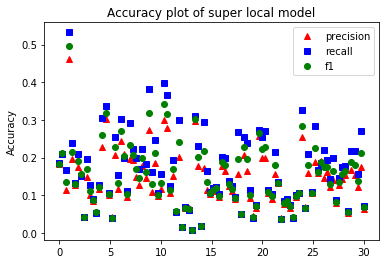

In [268]:

t = np.linspace(0., 30, 100)

# red dashes, blue squares and green triangles
plt.plot(t, precision_local_ss, 'r^',label='precision')
plt.plot(t, recall_local_ss, 'bs',label='recall')
plt.plot(t, f1_local_ss, 'go',label='f1')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot of super local model')
plt.legend()


In [269]:
print(f"Local HMM trained from superfamily dataset has precision: {np.mean(precision_local_ss)},\
 recall: {np.mean(recall_local_ss)}, f1: {np.mean(f1_local_ss)} ")

Local HMM trained from superfamily dataset has precision: 0.13959962573732296, recall: 0.17025187203562056, f1: 0.15265297783442647 


In [230]:
"""accuracy calculating for global HMM model trained of superfamily onto superfamily dataset"""
#global viterbi

precision_global_ss=[]
recall_global_ss =[]
f1_global_ss = []

l_para_vit = copy.deepcopy(g_para_super)

for seq_pair in super_list_test:

    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)

    #M,X,Y plus a dimension to store the index
    v_matrix = np.full([m+1,n+1, len(states),2], -np.inf)

    v_matrix[0,0,0,0] = np.log(1/3)
    v_matrix[0,0,1,0] = np.log(1/3)
    v_matrix[0,0,2,0] = np.log(1/3)
    for i in range(0,m+1):
        for j in range(0,n+1):
            if i==0 and j ==0: continue
            v_matrix[i,j,0,:] = forward_M_compute_v(i,j)
            v_matrix[i,j,1,:] = forward_X_compute_v(i,j)
            v_matrix[i,j,2,:] = forward_Y_compute_v(i,j)            


    seq1_aln, seq2_aln = global_backtracing(seq1,seq2,v_matrix)
    precision, recall, f1 = accuracy(seq_pair[0],seq_pair[1],seq1_aln,seq2_aln)
    precision_global_ss.append(precision)
    recall_global_ss.append(recall)
    f1_global_ss.append(f1)
    

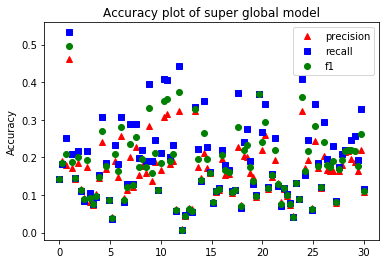

In [231]:

t = np.linspace(0., 30, 100)

# red dashes, blue squares and green triangles
plt.plot(t, precision_global_ss, 'r^',label='precision')
plt.plot(t, recall_global_ss, 'bs',label='recall')
plt.plot(t, f1_global_ss, 'go',label='f1')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot of super global model')
plt.legend()

In [232]:
print(f"global HMM trained from superfamily dataset has precision: {np.mean(precision_global_ss)},\
 recall: {np.mean(recall_global_ss)}, f1: {np.mean(f1_global_ss)} ")

global HMM trained from superfamily dataset has precision: 0.16195043878690535, recall: 0.19083277704049906, f1: 0.1742728308620195 


In [233]:
"""accuracy calculating for local HMM model trained of twilight onto twilight dataset"""
#local viterbi

precision_local_tt=[]
recall_local_tt =[]
f1_local_tt = []

l_para_vit = copy.deepcopy(l_para_twil)

for seq_pair in twil_list_test:
    
    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)

    #M,X,Y plus a dimension to store the index
    v_matrix = np.full([m+1,n+1, len(states),2], -np.inf)


    v_matrix[0,0,1,0] = np.log(0.5)
    v_matrix[0,0,2,0] = np.log(0.5)
    for i in range(0,m+1):
        for j in range(0,n+1):
            if i==0 and j ==0: continue
            v_matrix[i,j,0,:] = forward_M_compute_v(i,j)
            v_matrix[i,j,1,:] = forward_X_compute_v(i,j)
            v_matrix[i,j,2,:] = forward_Y_compute_v(i,j)            


    seq1_aln, seq2_aln = local_backtracing(seq1,seq2,v_matrix)
    precision, recall, f1 = accuracy(seq_pair[0],seq_pair[1],seq1_aln,seq2_aln)
    precision_local_tt.append(precision)
    recall_local_tt.append(recall)
    f1_local_tt.append(f1)
    

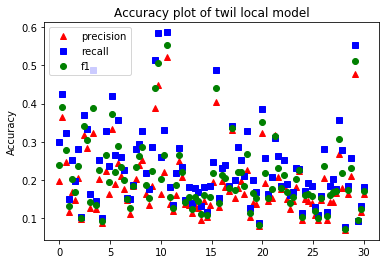

In [234]:

t = np.linspace(0., 30, 100)

# red dashes, blue squares and green triangles
plt.plot(t, precision_local_tt, 'r^',label='precision')
plt.plot(t, recall_local_tt, 'bs',label='recall')
plt.plot(t, f1_local_tt, 'go',label='f1')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot of twil local model')
plt.legend()


In [235]:
print(f"Local HMM trained from twilfamily dataset has precision: {np.mean(precision_local_tt)},\
 recall: {np.mean(recall_local_tt)}, f1: {np.mean(f1_local_tt)} ")

Local HMM trained from twilfamily dataset has precision: 0.18807076966315286, recall: 0.2369704209344629, f1: 0.2090630998850981 


In [237]:
"""accuracy calculating for global HMM model trained of twilight onto twilight dataset"""
#global viterbi

precision_global_tt=[]
recall_global_tt =[]
f1_global_tt = []

l_para_vit = copy.deepcopy(g_para_twil)

for seq_pair in twil_list_test:

    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)

    #M,X,Y plus a dimension to store the index
    v_matrix = np.full([m+1,n+1, len(states),2], -np.inf)

    v_matrix[0,0,0,0] = np.log(1/3)
    v_matrix[0,0,1,0] = np.log(1/3)
    v_matrix[0,0,2,0] = np.log(1/3)
    for i in range(0,m+1):
        for j in range(0,n+1):
            if i==0 and j ==0: continue
            v_matrix[i,j,0,:] = forward_M_compute_v(i,j)
            v_matrix[i,j,1,:] = forward_X_compute_v(i,j)
            v_matrix[i,j,2,:] = forward_Y_compute_v(i,j)            


    seq1_aln, seq2_aln = global_backtracing(seq1,seq2,v_matrix)
    precision, recall, f1 = accuracy(seq_pair[0],seq_pair[1],seq1_aln,seq2_aln)
    
    precision_global_tt.append(precision)
    recall_global_tt.append(recall)
    f1_global_tt.append(f1)
    

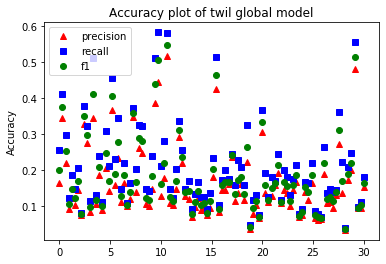

In [238]:

t = np.linspace(0., 30, 100)

# red dashes, blue squares and green triangles
plt.plot(t, precision_global_tt, 'r^',label='precision')
plt.plot(t, recall_global_tt, 'bs',label='recall')
plt.plot(t, f1_global_tt, 'go',label='f1')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot of twil global model')
plt.legend()

In [239]:
print(f"global HMM trained from twilfamily dataset has precision: {np.mean(precision_global_tt)},\
 recall: {np.mean(recall_global_tt)}, f1: {np.mean(f1_global_tt)} ")

global HMM trained from twilfamily dataset has precision: 0.16361888785939016, recall: 0.21133571282306718, f1: 0.18390099334040383 


In [240]:
"""accuracy calculating for local HMM model trained of superfamily onto twilight dataset"""
#local viterbi
#superfamily to twilight

precision_local_st=[]
recall_local_st =[]
f1_local_st = []

l_para_vit = copy.deepcopy(l_para_super)

for seq_pair in twil_list_test:
    
    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)

    #M,X,Y plus a dimension to store the index
    v_matrix = np.full([m+1,n+1, len(states),2], -np.inf)


    v_matrix[0,0,1,0] = np.log(0.5)
    v_matrix[0,0,2,0] = np.log(0.5)
    for i in range(0,m+1):
        for j in range(0,n+1):
            if i==0 and j ==0: continue
            v_matrix[i,j,0,:] = forward_M_compute_v(i,j)
            v_matrix[i,j,1,:] = forward_X_compute_v(i,j)
            v_matrix[i,j,2,:] = forward_Y_compute_v(i,j)            


    seq1_aln, seq2_aln = local_backtracing(seq1,seq2,v_matrix)
    precision, recall, f1 = accuracy(seq_pair[0],seq_pair[1],seq1_aln,seq2_aln)
    
    precision_local_st.append(precision)
    recall_local_st.append(recall)
    f1_local_st.append(f1)
    

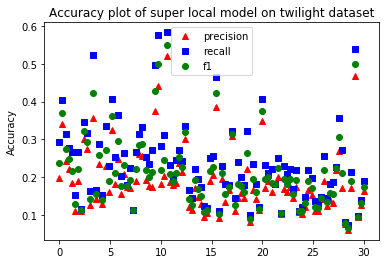

In [241]:
# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, 100)

# red dashes, blue squares and green triangles
plt.plot(t, precision_local_st, 'r^',label='precision')
plt.plot(t, recall_local_st, 'bs',label='recall')
plt.plot(t, f1_local_st, 'go',label='f1')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot of super local model on twilight dataset')
plt.legend()


In [242]:
print(f"Local HMM trained from superfamily dataset has precision: {np.mean(precision_local_st)},\
 recall: {np.mean(recall_local_st)}, f1: {np.mean(f1_local_st)} ")

Local HMM trained from superfamily dataset has precision: 0.18812863939816027, recall: 0.23739871062451848, f1: 0.2093055739634981 


In [243]:
"""accuracy calculating for global HMM model trained of superfamily onto twilight dataset"""
#global viterbi
#apply global model trained from superfamily to twilight dataset
precision_global_st=[]
recall_global_st =[]
f1_global_st = []

l_para_vit = copy.deepcopy(g_para_super)

for seq_pair in twil_list_test:

    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)

    #M,X,Y plus a dimension to store the index
    v_matrix = np.full([m+1,n+1, len(states),2], -np.inf)

    v_matrix[0,0,0,0] = np.log(1/3)
    v_matrix[0,0,1,0] = np.log(1/3)
    v_matrix[0,0,2,0] = np.log(1/3)
    for i in range(0,m+1):
        for j in range(0,n+1):
            if i==0 and j ==0: continue
            v_matrix[i,j,0,:] = forward_M_compute_v(i,j)
            v_matrix[i,j,1,:] = forward_X_compute_v(i,j)
            v_matrix[i,j,2,:] = forward_Y_compute_v(i,j)            


    seq1_aln, seq2_aln = global_backtracing(seq1,seq2,v_matrix)
    precision, recall, f1 = accuracy(seq_pair[0],seq_pair[1],seq1_aln,seq2_aln)
    
    precision_global_st.append(precision)
    recall_global_st.append(recall)
    f1_global_st.append(f1)
    

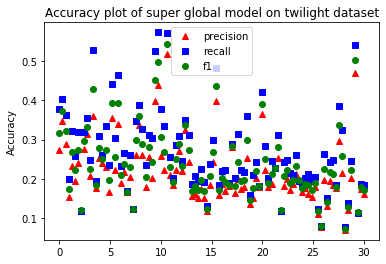

In [244]:

t = np.linspace(0., 30, 100)

# red dashes, blue squares and green triangles
plt.plot(t, precision_global_st, 'r^',label='precision')
plt.plot(t, recall_global_st, 'bs',label='recall')
plt.plot(t, f1_global_st, 'go',label='f1')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot of super global model on twilight dataset')
plt.legend()

In [245]:
print(f"global HMM trained from superfamily dataset has precision: {np.mean(precision_global_st)},\
 recall: {np.mean(recall_global_st)}, f1: {np.mean(f1_global_st)} ")

global HMM trained from superfamily dataset has precision: 0.21655679776450623, recall: 0.2667934896898755, f1: 0.23843377958409648 


In [246]:
"""accuracy calculating for local HMM model trained of twilight onto superfamily dataset"""
#local viterbi
#twilight to super
precision_local_ts=[]
recall_local_ts =[]
f1_local_ts = []

l_para_vit = copy.deepcopy(l_para_twil)

for seq_pair in super_list_test:
    
    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)

    #M,X,Y plus a dimension to store the index
    v_matrix = np.full([m+1,n+1, len(states),2], -np.inf)


    v_matrix[0,0,1,0] = np.log(0.5)
    v_matrix[0,0,2,0] = np.log(0.5)
    for i in range(0,m+1):
        for j in range(0,n+1):
            if i==0 and j ==0: continue
            v_matrix[i,j,0,:] = forward_M_compute_v(i,j)
            v_matrix[i,j,1,:] = forward_X_compute_v(i,j)
            v_matrix[i,j,2,:] = forward_Y_compute_v(i,j)            


    seq1_aln, seq2_aln = local_backtracing(seq1,seq2,v_matrix)
    precision, recall, f1 = accuracy(seq_pair[0],seq_pair[1],seq1_aln,seq2_aln)
    
    precision_local_ts.append(precision)
    recall_local_ts.append(recall)
    f1_local_ts.append(f1)
    

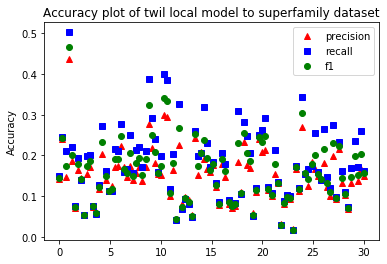

In [247]:

t = np.linspace(0., 30, 100)

# red dashes, blue squares and green triangles
plt.plot(t, precision_local_ts, 'r^',label='precision')
plt.plot(t, recall_local_ts, 'bs',label='recall')
plt.plot(t, f1_local_ts, 'go',label='f1')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot of twil local model to superfamily dataset')
plt.legend()


In [248]:
print(f"Local HMM trained from twilfamily dataset has precision: {np.mean(precision_local_ts)},\
 recall: {np.mean(recall_local_ts)}, f1: {np.mean(f1_local_ts)} ")

Local HMM trained from twilfamily dataset has precision: 0.15039429309041574, recall: 0.18047789672790196, f1: 0.16322383768011245 


In [249]:
"""accuracy calculating for global HMM model trained of twilight onto superfamily dataset"""
#global viterbi
#twil to super
precision_global_ts=[]
recall_global_ts =[]
f1_global_ts = []

l_para_vit = copy.deepcopy(g_para_twil)

for seq_pair in super_list_test:

    seq1,seq2 = pure_seq([seq_pair])[0]
    m = len(seq1)
    n = len(seq2)

    #M,X,Y plus a dimension to store the index
    v_matrix = np.full([m+1,n+1, len(states),2], -np.inf)

    v_matrix[0,0,0,0] = np.log(1/3)
    v_matrix[0,0,1,0] = np.log(1/3)
    v_matrix[0,0,2,0] = np.log(1/3)
    for i in range(0,m+1):
        for j in range(0,n+1):
            if i==0 and j ==0: continue
            v_matrix[i,j,0,:] = forward_M_compute_v(i,j)
            v_matrix[i,j,1,:] = forward_X_compute_v(i,j)
            v_matrix[i,j,2,:] = forward_Y_compute_v(i,j)            


    seq1_aln, seq2_aln = global_backtracing(seq1,seq2,v_matrix)
    precision, recall, f1 = accuracy(seq_pair[0],seq_pair[1],seq1_aln,seq2_aln)
    
    precision_global_ts.append(precision)
    recall_global_ts.append(recall)
    f1_global_ts.append(f1)
    

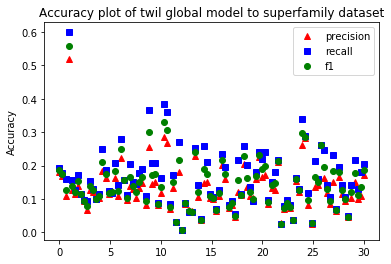

In [250]:
# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, 100)

# red dashes, blue squares and green triangles
plt.plot(t, precision_global_ts, 'r^',label='precision')
plt.plot(t, recall_global_ts, 'bs',label='recall')
plt.plot(t, f1_global_ts, 'go',label='f1')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot of twil global model to superfamily dataset')
plt.legend()

In [251]:
print(f"global HMM trained from twilfamily dataset has precision: {np.mean(precision_global_ts)},\
 recall: {np.mean(recall_global_ts)}, f1: {np.mean(f1_global_ts)} ")

global HMM trained from twilfamily dataset has precision: 0.13176823179562913, recall: 0.16205758288738245, f1: 0.1446183693787298 


Due to the limit of computational power and optimization, only 100 datapoints is used for training and 100 datapoints for testing, so all the accuracy value do not have any significance. 

The model implemented are two of the most simple pair HMM. One begin state, one end state, one insertion state for seq1, one insertion state for seq2 and a match state. Two insertion state do not have transition probability and local alignment model, match state do not transit from begin state or to end state. The begin state transition probability and end state transition probability are spread equally. 

For superfamily local model, it has precision: 0.14, recall: 0.17, f1: 0.15. However, this model performed better onto the twilight dataset, with precision: 0.18, recall:0.24, f1: 0.20. This happened same for superfamily global alignment model as well. It performed better on twilight dataset than on superfamily dataset. The general trend is that all the model performed better on twilight dataset than on superfamily dataset. Even it is counter intuitive that a model is perfomed better on a unseen dataset, but given the information that twilight dataset is less similar than superfamily, suggesting pairHMM is doing better with weak connections

For the model trained from same dataset, there is no general trend. For superfamily dataset, global alignment model performed better(f1 score:0.17 vs. 0.15). For twilight dataset, local alignment model performed better.(f1 score:0.21 vs. 0.18). I was expecting local alignment model would perform better on precision while global alignment model would perform better on recall. However, none of this happened. But this observation can be explained. Since accuracy for all the models are quite low, as superfamily dataset is more similar, global alignment with more converage would cover more hits, thus better precision as well. And since twilight dataset is less similar, local alignment model would better find those alignments.

The details of all the accuracy of different scenario can be seen from all the plots prior generated.